In [2]:
import scanpy as sc
import harmonypy as hm
import pandas as pd
from sklearn.decomposition import PCA


In [3]:

# 载入 h5ad 数据
adata = sc.read_h5ad("/root/Desktop/my_pan/workspace/Data/h5ad_output/new_fixed_bonemarrow_merged_data.h5ad")

# 确保有 batch 信息
assert "batch" in adata.obs.columns

# Step 1: PCA（可选：如果你没有 .obsm["X_pca"]）
if "X_pca" not in adata.obsm:
    print("⚠️ No PCA found, computing...")
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True)
    sc.pp.scale(adata)
    sc.tl.pca(adata, svd_solver='arpack', n_comps=50)


⚠️ No PCA found, computing...


In [4]:

# Step 2: Run Harmony
print("🔁 Running Harmony...")
ho = hm.run_harmony(adata.obsm["X_pca"], adata.obs,vars_use=["batch"], max_iter_harmony=20)


2025-05-23 15:18:51,692 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


🔁 Running Harmony...


2025-05-23 15:19:05,578 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-05-23 15:19:05,799 - harmonypy - INFO - Iteration 1 of 20
2025-05-23 15:19:13,170 - harmonypy - INFO - Iteration 2 of 20
2025-05-23 15:19:20,901 - harmonypy - INFO - Iteration 3 of 20
2025-05-23 15:19:24,112 - harmonypy - INFO - Converged after 3 iterations


/root/miniconda3/envs/harmonypy38/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/root/miniconda3/envs/harmonypy38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/root/miniconda3/envs/harmonypy38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


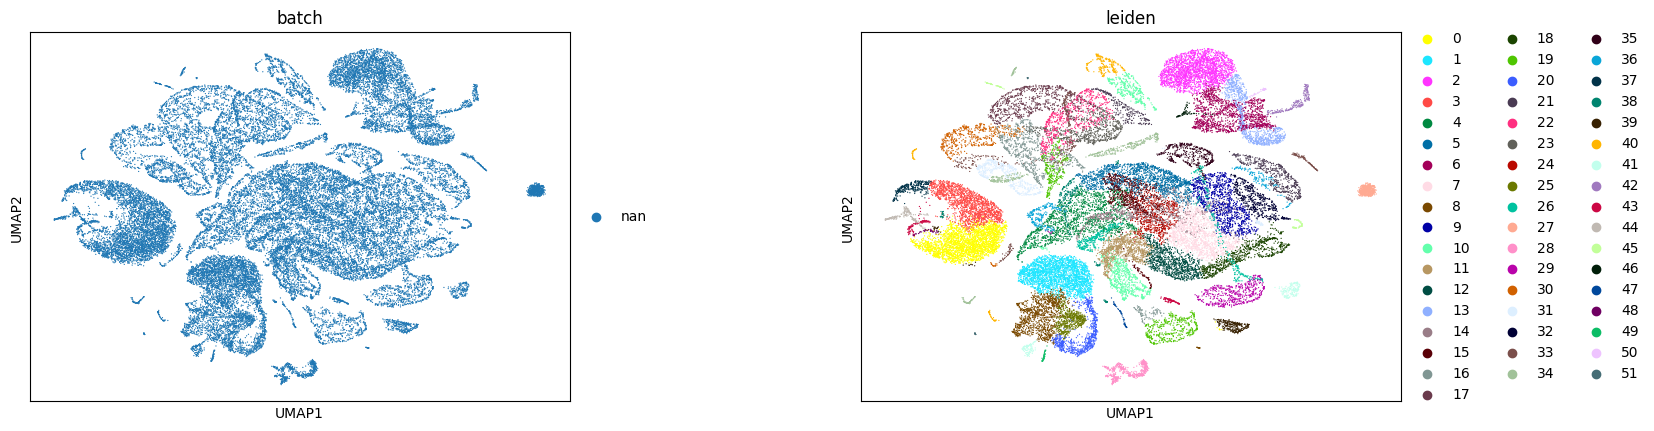

✅ Harmony 整合完成并保存！


In [6]:

# Step 3: 把修正后的嵌入添加到 AnnData
adata.obsm["X_harmony"] = ho.Z_corr.T

# Step 4: 后续聚类与 UMAP
sc.pp.neighbors(adata, use_rep="X_harmony")
sc.tl.umap(adata)
sc.tl.leiden(adata)

# Step 5: 可视化
sc.pl.umap(adata, color=["batch", "leiden"], wspace=0.4)

# Step 6: 保存
adata.write_h5ad("/root/Desktop/my_pan/workspace/Data/h5ad_output/harmony_corrected_bonemarrow.h5ad")
print("✅ Harmony 整合完成并保存！")


In [9]:
adata.obs["batch"] = adata.obs_names.str.split("_").str[0]
adata.obs["batch"] = adata.obs["batch"].astype("category")
adata.write_h5ad("/root/Desktop/my_pan/workspace/Data/h5ad_output/harmony_corrected_bonemarrow.h5ad")


In [1]:
import scanpy as sc
import numpy as np
from scipy.sparse import csr_matrix

# 读取原始 .h5ad 文件
adata = sc.read_h5ad("/root/Desktop/my_pan/workspace/Data/h5ad_output/new_fixed_bonemarrow_merged_data.h5ad")

# 确保 .X 是 float32 且为 csr 稀疏格式
if not isinstance(adata.X, csr_matrix):
    adata.X = csr_matrix(adata.X)

adata.X = adata.X.astype(np.float32)

# 修复非唯一细胞名
adata.obs_names_make_unique()

# 替换 gene 名中的 "_"
adata.var_names = [v.replace("_", "-") for v in adata.var_names]
adata.var_names_make_unique()

# 保存为新的修复版
adata.write("/root/Desktop/my_pan/workspace/Data/h5ad_output/for_R_fixed_bone_marrow.h5ad")



In [2]:
import scanpy as sc

adata = sc.read_h5ad("/root/Desktop/my_pan/workspace/Data/h5ad_output/for_R_fixed_bone_marrow.h5ad")

# 强制将所有 categorical obs 列转换为字符串
for col in adata.obs.columns:
    if adata.obs[col].dtype.name == "category":
        adata.obs[col] = adata.obs[col].astype(str)

# 确保基因/细胞名唯一
adata.obs_names_make_unique()
adata.var_names_make_unique()

# 保存新的安全格式
adata.write("/root/Desktop/my_pan/workspace/Data/h5ad_output/final_cleaned_bone_marrow.h5ad")
